In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import matplotlib

np.random.seed(420)

# Poblacion y Salud
## Representacion de datos de entrada para el modelo de posicionamiento
Considerando las comunas de Valparaiso, Viña del Mar y San Antonio como objetos de estudio, este notebook muestra el preprocesamiento hecho para obtener la posicion de las manzanas, centros de salud y nuevas posibles ubicaciones, asi como tambien la creacion de muestras aleatorias.


In [2]:
# Comuna a estudiar
comuna = [
#         'SAN ANTONIO', 
#         'VALPARAÍSO', 
        'VIÑA DEL MAR'
        ]
# Importamos datos de poblacion, ubicacion y poblacion por edad
poblacion = pd.read_csv('poblacion/EdadUbicacionPoblacion.csv')
poblacion = poblacion[poblacion.Comuna.isin(comuna)]
poblacion.rename({'Edad<=5':'Edad<5', 'Edad6-14':'Edad5-14', 'Edad15-64':'Edad15-64',
                'Edad>65':'Edad>64'},axis = 1, inplace = True)

# Cambiamos la ubicacion de latitud y longitud a -100, 100
from sklearn.preprocessing import StandardScaler
x_scaler = StandardScaler().fit(poblacion.x.to_numpy().reshape(-1, 1))
y_scaler = StandardScaler().fit(poblacion.y.to_numpy().reshape(-1, 1))
poblacion['x'] = x_scaler.transform(poblacion.x.to_numpy().reshape(-1, 1))/2*100
poblacion['y'] = y_scaler.transform(poblacion.y.to_numpy().reshape(-1, 1))/2.5*100

# Importamos los datos de salud, posicion y tipo de establecimiento
salud = pd.read_csv('UbicacionSalud.csv')
salud = salud[salud.Prestador == 'Público ']
salud.Comuna = salud.Comuna.str.upper()
salud = salud[salud.Comuna.isin(comuna)]
# Aplicamos la trasnformacion de ubicaciones
salud['x'] = x_scaler.transform(salud.x.to_numpy().reshape(-1, 1))/2*100
salud['y'] = y_scaler.transform(salud.y.to_numpy().reshape(-1, 1))/2.5*100

In [3]:
poblacion.head()

,Comuna,Region,Personas,Hombres,Mujeres,Edad<5,Edad5-14,Edad15-64,Edad>64,Area,geometry,x,y
4610,VIÑA DEL MAR,REGIÓN DE VALPARAÍSO,25,0,0,0,0,19,0,85742.482422,"POLYGON ((-71.564990410579 -33.0189413811766, ...",-80.889757,-5.937657
4611,VIÑA DEL MAR,REGIÓN DE VALPARAÍSO,49,22,27,0,0,35,12,5842.228516,"POLYGON ((-71.5652814437836 -33.0230415783429,...",-76.276516,-6.955372
4612,VIÑA DEL MAR,REGIÓN DE VALPARAÍSO,34,14,20,0,0,25,0,5733.906250,"POLYGON ((-71.5644812180337 -33.0231653340496,...",-74.743607,-7.168136
4613,VIÑA DEL MAR,REGIÓN DE VALPARAÍSO,31,15,16,0,0,20,0,8288.386719,"POLYGON ((-71.5636478621591 -33.0239855805069,...",-73.290910,-8.533513
4614,VIÑA DEL MAR,REGIÓN DE VALPARAÍSO,77,36,41,0,0,61,10,12547.417969,"POLYGON ((-71.5645986551038 -33.023856839858, ...",-75.475050,-8.267383


In [4]:
# Definimos cuales tipos de establecimiento modelaremos
def tipo_establecimiento(x):
    if x in [ 'Hospital ', 'Hospital']:
        return 'Hospital'
    elif x in ['Posta de Salud Rural (PSR)','Centro Comunitario de Salud Familiar (CECOSF)',
               'Centro de Salud Familiar (CESFAM)', 'Consultorio General Urbano (CGU)',
               'Consultorio de Diagnóstico y Tratamiento (CDT)',
               'Centro de Referencia de Salud (CRS)']:
        return 'Rutinario'
    elif x in ['Servicio de Atención Primaria de Urgencia (SAPU)','Servicio de Urgencia Rural (SUR)',
               'Servicio de Atención Primaria de Urgencia de Alta Resolutividad (SAR)']:
        return 'Urgencias'
    else:
        return 'Otro'
# Quitamos del estudio todos los registros que no utilizaremos
salud['Tipo'] = salud.Tipo.apply(tipo_establecimiento)
salud=salud[salud.Tipo!= 'Otro']

In [5]:
salud.head()

,ID,Region,Tipo,Nombre,Comuna,y,x,Prestador,Complejidad
76,107100,Región De Valparaíso,Hospital,Hospital Dr. Gustavo Fricke (Viña del Mar),VIÑA DEL MAR,-18.878255,-31.062672,Público,Alta Complejidad
93,107300,Región De Valparaíso,Rutinario,Centro de Salud Familiar Nueva Aurora,VIÑA DEL MAR,-52.485582,-74.315933,Público,Baja Complejidad
94,107301,Región De Valparaíso,Rutinario,Centro de Salud Familiar Profesor Eugenio Cien...,VIÑA DEL MAR,25.872194,-29.300285,Público,Baja Complejidad
95,107302,Región De Valparaíso,Rutinario,Centro de Salud Familiar Miraflores,VIÑA DEL MAR,-2.489830,18.744170,Público,Baja Complejidad
96,107303,Región De Valparaíso,Rutinario,Centro de Salud Familiar Gómez Carreño,VIÑA DEL MAR,47.727023,-0.416822,Público,Baja Complejidad


## Posicion de poblacion y centros de salud: Data Real

In [6]:
def plot_data(poblacion, salud, titulo):
    plt.figure(figsize = (12,10))
    ax = plt.gca()
    plt.scatter(poblacion.x,poblacion.y,edgecolors='none',marker = '.',c=poblacion.Personas,
                    norm=matplotlib.colors.LogNorm())
    plt.colorbar()
    color = ['k','b','r']
    for i,tipo in enumerate(salud.Tipo.unique()):
        salud2= salud[salud.Tipo == tipo]
        plt.scatter(salud2.x,salud2.y, edgecolors='none', c = color[i], marker = 'o', label = tipo)
    plt.legend()
    plt.title(titulo)
    ax.set_aspect('equal', adjustable='box')
    plt.show()

In [7]:
poblacion[['Edad<5', 'Edad5-14', 'Edad15-64', 'Edad>64']].describe()

,Edad<5,Edad5-14,Edad15-64,Edad>64
count,3738.000000,3738.000000,3738.000000,3738.000000
mean,4.899679,7.698502,63.013376,12.598181
std,10.761100,14.577515,95.977538,20.479197
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,22.250000,0.000000
50%,0.000000,4.000000,38.000000,8.000000
75%,6.000000,10.000000,65.000000,15.000000
max,195.000000,321.000000,2309.000000,449.000000


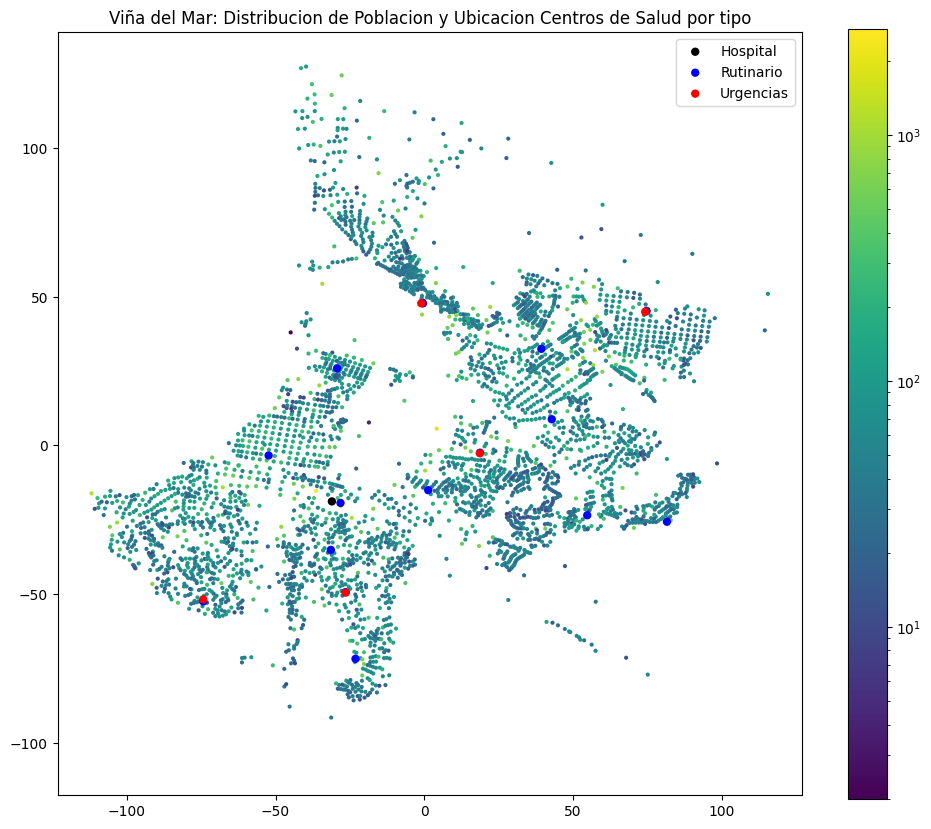

In [8]:
plot_data(poblacion, salud, 'Viña del Mar: Distribucion de Poblacion y Ubicacion Centros de Salud por tipo')

## Analisis de poblacion, distribucion de edades por manzana
Vemos la distribucion de personas por edad en la comuna, los registros son a nivel de manzana.

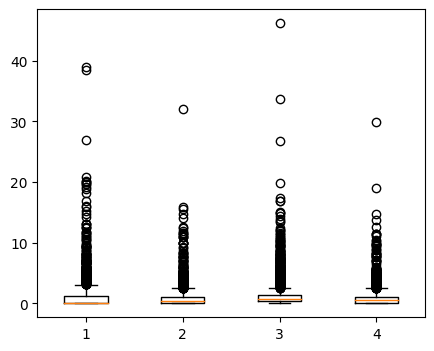

In [9]:
# Escalamos los datos segun la cantidad de edades del grupo, para nivelar las medidas
boxplot_data = poblacion[['Edad<5','Edad5-14', 'Edad15-64', 'Edad>64']].copy()
boxplot_data['Edad<5'] =    boxplot_data['Edad<5']/5
boxplot_data['Edad5-14'] =  boxplot_data['Edad5-14']/10
boxplot_data['Edad15-64'] = boxplot_data['Edad15-64']/50
boxplot_data['Edad>64'] =   boxplot_data['Edad>64']/15
# 
fig = plt.figure(figsize =(5, 4))
plt.boxplot(boxplot_data)
plt.show()

In [10]:
# Analizando la distribucion de personas por edad en la comuna 
distribucion_poblacion = poblacion[['Edad<5','Edad5-14','Edad15-64','Edad>64']].describe().reset_index()[1:3]
distribucion_poblacion

,index,Edad<5,Edad5-14,Edad15-64,Edad>64
1,mean,4.899679,7.698502,63.013376,12.598181
2,std,10.761100,14.577515,95.977538,20.479197


In [11]:
# Vemos la distribucion de tipos de centros de salud en la comuna
total = len(salud)
(salud.groupby('Tipo').count()/total).reset_index()[['Tipo','ID']]

,Tipo,ID
0,Hospital,0.047619
1,Rutinario,0.714286
2,Urgencias,0.238095


## Creacion de muestras sinteticas

In [12]:
# Con estos datos generaremos las muestras de poblacion y salud que ingresaran al modelo
# Los limites de la posicion en el plano están entre -100 y 100 por comodidad
pos_min, pos_max = -100, 100
cantidad_manzanas = len(poblacion)
# Parametros para creacion de muestra de poblacion
# Esta se genera mediante una normal con los siguientes parametros
distribucion_poblacion = {'Edad<5':{'mean':4.9, 'std':10.76},
                          'Edad5-14':{'mean':7.7, 'std':15.58},
                          'Edad15-64':{'mean':63.01, 'std':95.98},
                          'Edad>64':{'mean':12.6, 'std':20.48}}

# Generamos como un dado cargado el tipo de establecimiento
cantidad_salud = 21
tipo_instalacion = ['Hospital', 'Rutinario', 'Urgencias']
prob_instalacion = [0.048,0.714,0.238]

In [13]:
# Esta poblacion se genera de manera aleatoria con una uniforme en el plano
# Su poblacion se genera mediante una normal con los parametros anteriores
# Truncando a 0 la poblacion negativa
# Se define la posicion de los centros de salud fijos como algunas de las manzanas actuales
# El tipo de centro se elige con un dado cargado por la probabilidad de cada tipo en la comuna
def crear_poblacion_aleatoria(cantidad_manzanas, cantidad_salud, distribucion_poblacion,
                              tipo_instalacion, prob_instalacion, pos_min, pos_max):
    poblacion = pd.DataFrame()
    for key in distribucion_poblacion.keys():
        poblacion[key] = np.ceil(np.random.normal(distribucion_poblacion[key]['mean'], 
                                             distribucion_poblacion[key]['std'], cantidad_manzanas))
    poblacion = poblacion.clip(lower=0)
    poblacion['Personas'] = poblacion[['Edad<5', 'Edad5-14', 'Edad15-64', 'Edad>64']].sum(axis = 1)
    poblacion['x'] = np.random.uniform(pos_min, pos_max, cantidad_manzanas)
    poblacion['y'] = np.random.uniform(pos_min, pos_max, cantidad_manzanas)
    
    salud = pd.DataFrame()
    salud_pos = np.random.choice(range(len(poblacion)), cantidad_salud)
    salud['x'] = poblacion.x.iloc[salud_pos]
    salud['y'] = poblacion.y.iloc[salud_pos]
    salud['Tipo'] = np.random.choice(tipo_instalacion,cantidad_salud, p = prob_instalacion)
    return poblacion, salud

# Esta es igual a la anterior en la creacion de poblacion y datos de salud
# Solo varia la posicion de la poblacion al crearse como manchas en el plano
def crear_poblacion_blobs(cantidad_manzanas, cantidad_salud, distribucion_poblacion,
                          tipo_instalacion, prob_instalacion, pos_min, pos_max):
    poblacion = pd.DataFrame()
    for key in distribucion_poblacion.keys():
        poblacion[key] = np.ceil(np.random.normal(distribucion_poblacion[key]['mean'], 
                                                 distribucion_poblacion[key]['std'], cantidad_manzanas))
    poblacion = poblacion.clip(lower=0)
    poblacion['Personas'] = poblacion[['Edad<5', 'Edad5-14', 'Edad15-64', 'Edad>64']].sum(axis = 1)
    from sklearn.datasets import make_blobs
    pos, _ = make_blobs(n_samples=cantidad_manzanas, centers=5, n_features=2, cluster_std = 3)
    from scipy.stats import zscore
    poblacion['x'] = zscore(pos[:,0])/2*100
    poblacion['y'] = zscore(pos[:,1])/2*100
    
    salud = pd.DataFrame()
    salud_pos = np.random.choice(range(len(poblacion)), cantidad_salud)
    salud['x'] = poblacion.x.iloc[salud_pos]
    salud['y'] = poblacion.y.iloc[salud_pos]
    salud['Tipo'] = np.random.choice(tipo_instalacion,cantidad_salud, p = prob_instalacion)
    return poblacion, salud

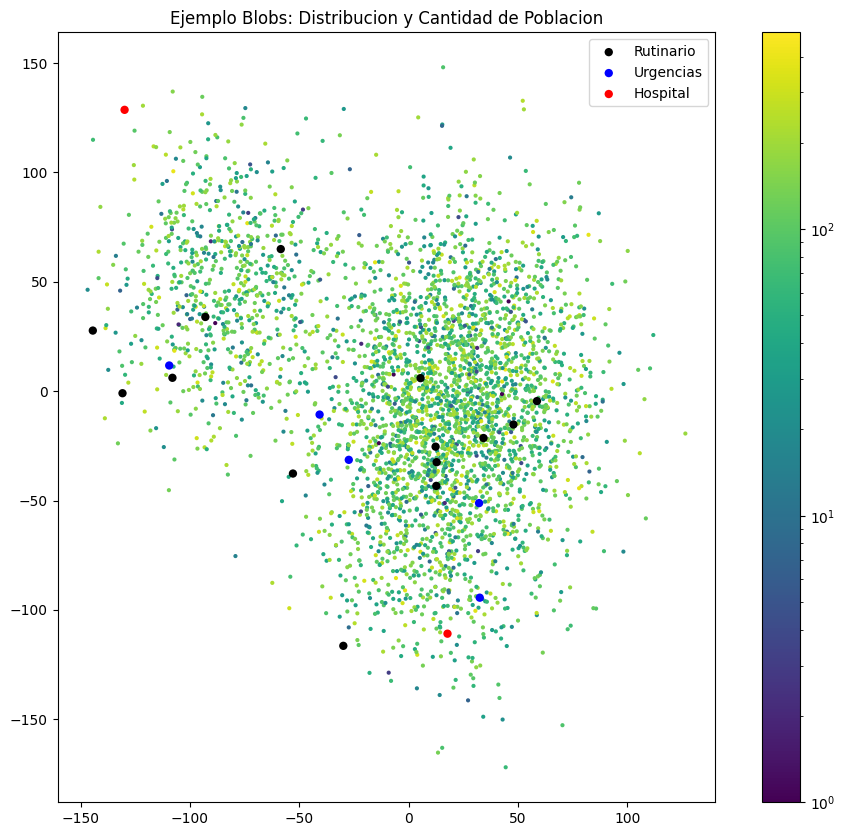

In [14]:
poblacion_blobs, salud_blobs = crear_poblacion_blobs(cantidad_manzanas, cantidad_salud, 
             distribucion_poblacion,tipo_instalacion, prob_instalacion, pos_min, pos_max)
plot_data(poblacion_blobs, salud_blobs,'Ejemplo Blobs: Distribucion y Cantidad de Poblacion')

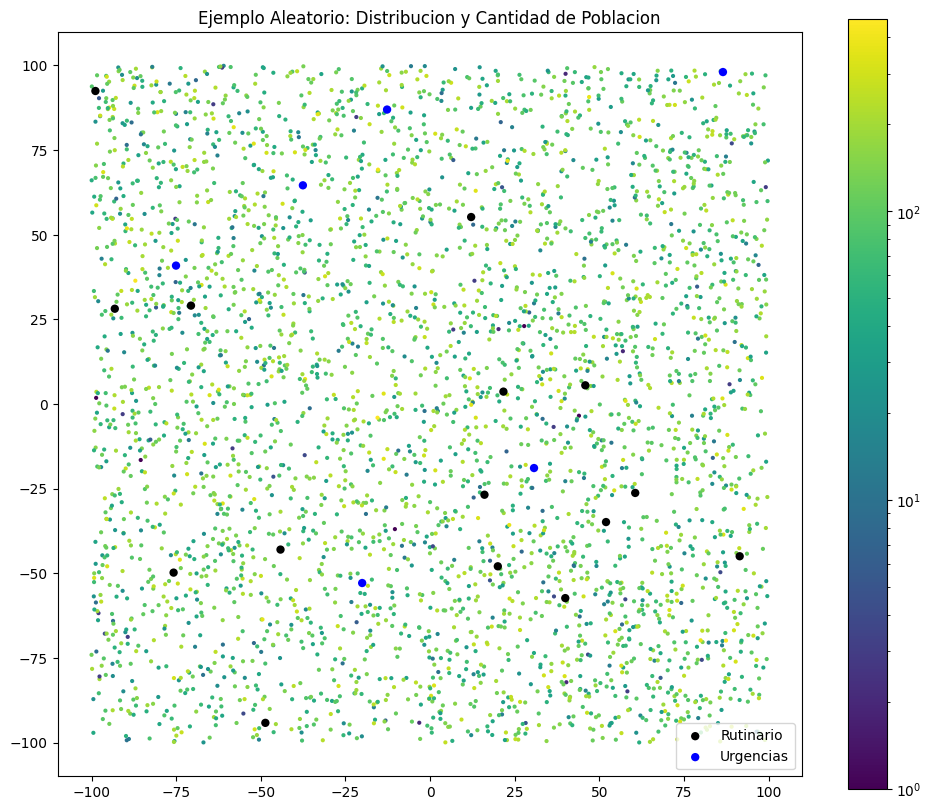

In [15]:
poblacion_aleatoria, salud_aleatoria = crear_poblacion_aleatoria(cantidad_manzanas, cantidad_salud, 
                 distribucion_poblacion,tipo_instalacion, prob_instalacion, pos_min, pos_max)
plot_data(poblacion_aleatoria, salud_aleatoria, 'Ejemplo Aleatorio: Distribucion y Cantidad de Poblacion')

## Nuevas posibles ubicaciones: 
### K-means modificado

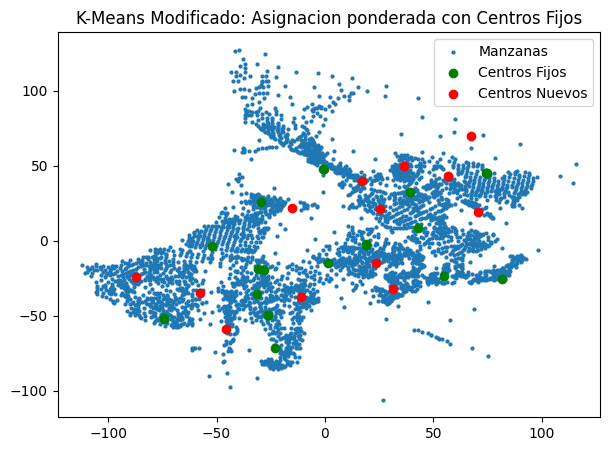

In [16]:
# Funcion de distancia L1 robada del algoritmo genetico
def l1_distance(demand_pos, supply_pos):
    distance = np.zeros((len(demand_pos),len(supply_pos)))
    for i in range(len(demand_pos)):
        for j in range(len(supply_pos)):
            distance[i,j] = np.abs(demand_pos[i,0] - supply_pos[j,0]) + np.abs(demand_pos[i,1] - supply_pos[j,1])
    return distance

# Asignacion de cada centro a la manzana cuya distancia ponderada sea minima
def asignacion(pos_manzana, centros_fijos, centros_nuevos, personas):
    centros = np.vstack([centros_fijos, centros_nuevos])
    distancias = l1_distance(pos_manzana, centros)
    asignaciones = np.argmin(distancias*personas.reshape((personas.shape[0],1)), axis=1)
    return asignaciones

# Mover centro a la distancia media de sus manzanas asignadas
def actualizar_centros_nuevos(pos_manzana, asignaciones, fijos, k):
    centros_nuevos = np.zeros((k, 2))
    for i in range(fijos, fijos + k):
        asignados = pos_manzana[asignaciones == i]
        if len(asignados) > 0:
            centros_nuevos[i - fijos] = np.mean(asignados, axis=0)
    return centros_nuevos

# Datos de entrada para el generador de nuevos centros
pos_manzana = poblacion[['x','y']].to_numpy()
pos_salud = salud[['x','y']].to_numpy()
personas = poblacion.Personas.to_numpy()

# Parametros 
k = 13 # Cantidad de nuevos centros
fijos = len(pos_salud) # cantidad de centros fijos
num_iteraciones = 10  # iteraciones totales

# Inicializamos como una recta que recorre todo el plano
# centros_nuevos = np.array([[i, i] for i in range(-100, 100, k)])
centros_nuevos = np.array([[i, i] for i in range(-80, 80, k)])


# Para cada iteracion actualizamos la posicion de los nuevos centros
for i in range(num_iteraciones):
    asignaciones = asignacion(pos_manzana, pos_salud, centros_nuevos, personas)
    centros_nuevos = actualizar_centros_nuevos(pos_manzana, asignaciones, fijos, k)
    
# Graficamos la posicion final
plt.figure(figsize = (7,5))
plt.scatter(pos_manzana[:, 0], pos_manzana[:, 1], s = 4, label='Manzanas')
plt.scatter(pos_salud[:, 0], pos_salud[:, 1], c='green', label='Centros Fijos')
plt.scatter(centros_nuevos[:, 0], centros_nuevos[:, 1], c='red', label='Centros Nuevos')
plt.legend()
plt.title('K-Means Modificado: Asignacion ponderada con Centros Fijos')
plt.show()

Con este algoritmo crearemos un conjunto de datos que considere multiples valores de k, estos serán los ingresados al modelo posteriormente

In [17]:
def nuevos_centros_kmeans(poblacion, salud, lista_k, titulo):
    # Definimos los parametros de entrada para el algoritmo
    pos_manzana = poblacion[['x','y']].to_numpy()
    pos_salud = salud[['x','y']].to_numpy()
    personas = poblacion.Personas.to_numpy()
    fijos = len(salud)
    num_iteraciones = 10
    # Para cada cantidad de centros neuvos
    l = []
    for k in lista_k:
        # Solucion inicial 
        centros_nuevos = np.array([[i,i] for i in range(-80, 100, k)])
        for i in range(num_iteraciones):
            asignaciones = asignacion(pos_manzana, pos_salud, centros_nuevos, personas)
            centros_nuevos = actualizar_centros_nuevos(pos_manzana, asignaciones, fijos, k)
        l.append(centros_nuevos)
    # Juntamos los centros resultantes
    x, y  = np.concatenate(l).T
    tipo = 'Por Definir'
    centros_nuevos = pd.DataFrame({'Tipo':tipo,'x':x, 'y':y})
    # Agregamos los resultados al dataframe
    salud = pd.concat([salud[['Tipo','x','y']],centros_nuevos]).reset_index(drop = True)
    # Imprimimos los resultados
    plt.figure(figsize = (7,5))
    plt.scatter(pos_manzana[:, 0], pos_manzana[:, 1], s = 4, label='Manzanas')
    plt.scatter(pos_salud[:, 0], pos_salud[:, 1], c='green', label='Centros Fijos')
    plt.scatter(np.concatenate(l)[:, 0], np.concatenate(l)[:, 1], c='red', label='Centros Nuevos')
    plt.legend()
    plt.title('Input Modelo: Posicion Poblacion y Salud')
    plt.show()
    # Guardamos los datos en archivos
    poblacion[['x','y','Edad<5','Edad5-14','Edad15-64','Edad>64','Personas']].to_csv('input_poblacion_'+titulo+'.csv', index = False)
    salud.to_csv('input_salud_'+titulo+'.csv', index = False)

# Creacion de datasets 
Consideraremos 2 instancias para cada tipo de representacion, para esto nos basaremos en las caracteristicas de la comuna de viña del mar y la union entre valparaiso y viña. Con estos parametros generaremos una muestra aleatoria y una de blobs para cada una, consiguiendo asi 6 casos de prueba para los modelos.

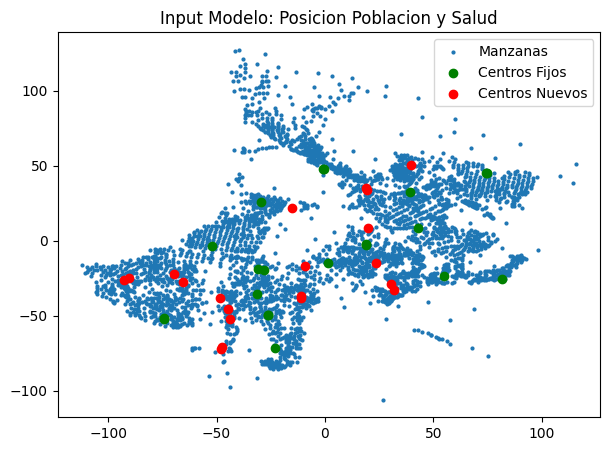

In [18]:
nuevos_centros_kmeans(poblacion, salud, [9,11], 'vina')

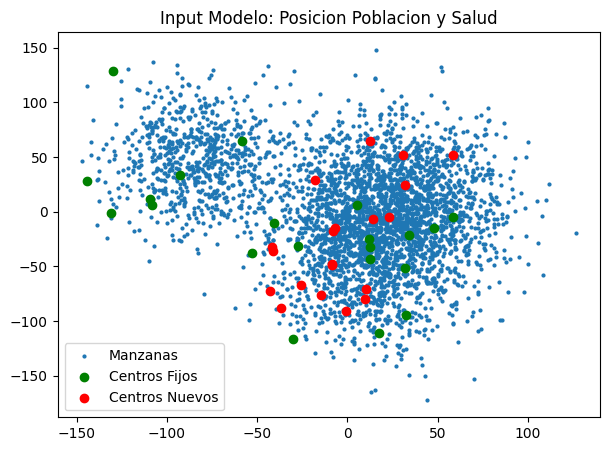

In [19]:
nuevos_centros_kmeans(poblacion_blobs, salud_blobs, [9,11], 'blobs_vina')

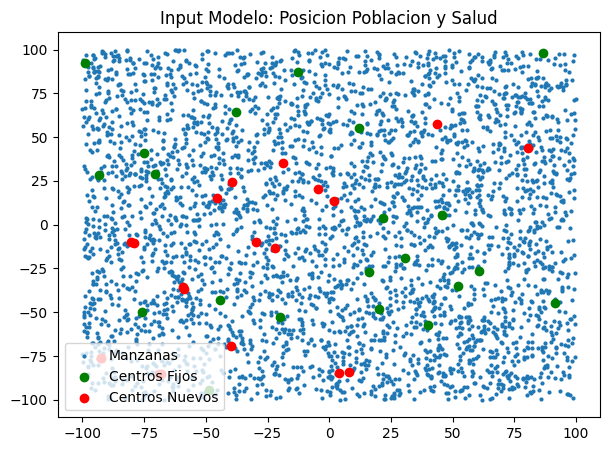

In [20]:
nuevos_centros_kmeans(poblacion_aleatoria, salud_aleatoria, [9,11], 'aleatoria_vina')